# Statistical Modelling

- I will use a hierarchical bayesian linear model like Twieki uses here: https://github.com/github/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb 

In [1]:
import theano

In [2]:
theano.config.device

'cpu'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [4]:
sns.set_style('whitegrid')

In [5]:
## load the data
df_cases = pd.read_pickle('./corona_scotland_regions_ts.pk')
df_total = pd.read_pickle('./corona_scotland_total_stats.pk')

In [6]:
max_num_days = len(df_cases)
max_num_days

44

In [7]:
## remove cases where there are hardly any cases
drop_cols = df_cases.columns[df_cases.quantile(0.5) == 0.0]
print(drop_cols)

df_cases = df_cases.drop(columns=drop_cols)

Index(['Eileanan Siar (Western Isles)', 'Orkney'], dtype='object', name='Health Board')


In [8]:
regions = df_cases.columns.values[:-1]
n_regions = len(regions)

In [9]:
np.argwhere(df_cases[regions[0]].gt(10).values).ravel()[0]

13

In [10]:
## find starting days
min_cases = 10
starting_days = {r: np.argwhere(df_cases[r].ge(min_cases).values).ravel()[0] for r in regions}
starting_days

{'Ayrshire and Arran': 13,
 'Borders': 15,
 'Dumfries and Galloway': 14,
 'Fife': 14,
 'Forth Valley': 9,
 'Grampian': 7,
 'Greater Glasgow and Clyde': 6,
 'Highland': 17,
 'Lanarkshire': 8,
 'Lothian': 6,
 'Shetland': 8,
 'Tayside': 8}

In [11]:
def doubling_time(r):
    i = 0
    while True:
        x = (1 + r)**i
        if x >= 2:
            break
        else:
            i += 1
    return i, x

In [12]:
rates = [0.33, 0.25, 0.2, 0.17, 0.15, 0.12, 0.10, 0.08, 0.05, 0.02, 0.01]
print('## Doubling Times ##')
for r in rates:
    t, x = doubling_time(r)
    print(f"r={r:.2f}\t=>   {t} days ; (factor={x:.3f})")

## Doubling Times ##
r=0.33	=>   3 days ; (factor=2.353)
r=0.25	=>   4 days ; (factor=2.441)
r=0.20	=>   4 days ; (factor=2.074)
r=0.17	=>   5 days ; (factor=2.192)
r=0.15	=>   5 days ; (factor=2.011)
r=0.12	=>   7 days ; (factor=2.211)
r=0.10	=>   8 days ; (factor=2.144)
r=0.08	=>   10 days ; (factor=2.159)
r=0.05	=>   15 days ; (factor=2.079)
r=0.02	=>   36 days ; (factor=2.040)
r=0.01	=>   70 days ; (factor=2.007)


In [13]:
print(f"{0.1:.5f}")

0.10000


In [14]:
doubling_time(0.25)

(4, 2.44140625)

In [15]:
doubling_time(0.15)

(5, 2.0113571874999994)

In [16]:
doubling_time(0.10)

(8, 2.1435888100000016)

### Whole of Scotland

Text(0, 0.5, 'Num Confirmed Cases')

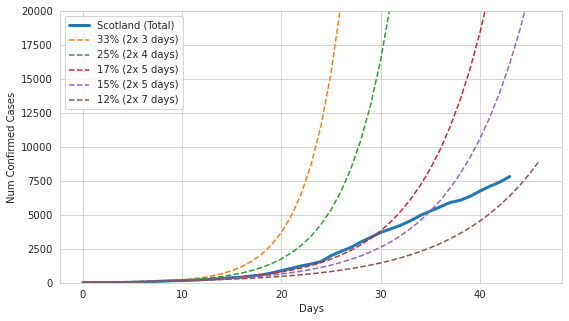

In [17]:
i = 8
max_days = 47
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3)
plt.plot(c*(1 + 0.33) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='33% (2x 3 days)')

plt.plot(c*(1 + 0.25) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='25% (2x 4 days)')
plt.plot(c*(1 + 0.17) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='17% (2x 5 days)')
plt.plot(c*(1 + 0.15) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 5 days)')
plt.plot(c*(1 + 0.12) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='12% (2x 7 days)')
plt.legend()
plt.ylim(0, 20000)
plt.xlabel('Days')
plt.ylabel('Num Confirmed Cases')

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


Text(0, 0.5, 'Num Confirmed Cases')

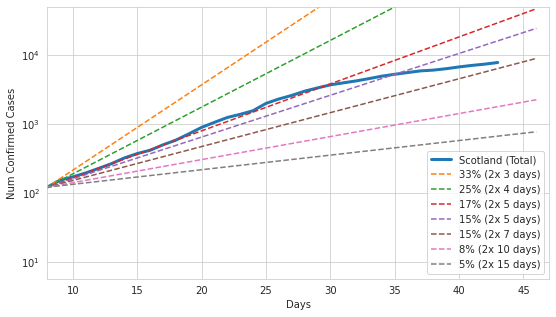

In [18]:
i = 8
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3, logy=True)
plt.plot(c*(1 + 0.33) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='33% (2x 3 days)')

plt.plot(c*(1 + 0.25) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='25% (2x 4 days)')
plt.plot(c*(1 + 0.17) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='17% (2x 5 days)')
plt.plot(c*(1 + 0.15) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 5 days)')
plt.plot(c*(1 + 0.12) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 7 days)')
plt.plot(c*(1 + 0.08) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='8% (2x 10 days)')
plt.plot(c*(1 + 0.05) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='5% (2x 15 days)')
plt.legend()
plt.ylim(0, 50000)
plt.xlim(i, max_days)
plt.xlabel('Days')
plt.ylabel('Num Confirmed Cases')

In [19]:
with pm.Model() as model_scotland:
    
    ### Intercepts ###
    b = pm.Normal('b', 10, 5)
    
    
    ### Slopes ###
    a = pm.Normal('a', 1.12, 0.5)
    
    ### Error ###
    sigma = pm.HalfCauchy('sigma', 50.)
    
    ### Likelihood for Each Region ###
    cases = df_cases['Scotland (Total)'].values[10:]
        
    # From Twieki:
    # By using pm.Data we can change these values after sampling.
    # This allows us to extend x into the future so we can get
    # forecasts by sampling from the posterior predictive
    x = pm.Data('x_data',
                np.arange(10, max_num_days, 1))
    confirmed = pm.Data('y_data',
                        cases)

    # Likelihood
    pm.NegativeBinomial(
        'Scotland (Total)',
        (b * a ** (x-8)), # Exponential regression
        sigma,
        observed=confirmed)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


In [20]:
with model_scotland:
    # Sample posterior
    trace_scotland = pm.sample(tune=1000, draws=2000, 
                               chains=2, cores=4, target_accept=0.9,
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, b]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:18<00:00, 324.56draws/s]


In [21]:
with model_scotland:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, max_days)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({'x_data': x_data})
    pm.set_data({'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_scotland, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:08<00:00, 23.78it/s]


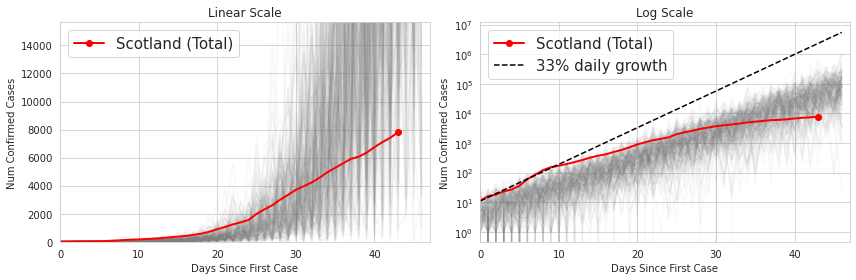

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))
r = 'Scotland (Total)'
y = df_cases[r].iloc[:].values

ax = axes[0]
for sim in post_pred[r]:
    ax.plot(sim, color='gray', alpha=0.05)
ax.plot(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
#ax.plot(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, max_days)
ax.set_ylim(0, 2*y.max())
ax.set_xlabel('Days Since First Case')
ax.set_ylabel('Num Confirmed Cases')
ax.set_title('Linear Scale')
ax.legend(fontsize=15)

ax = axes[1]
for sim in post_pred[r]:
    ax.semilogy(sim, color='gray', alpha=0.05)
ax.semilogy(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
ax.semilogy(y[0] * 1.33 ** np.arange(0, max_days), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, max_days)
ax.set_xlabel('Days Since First Case')
ax.set_ylabel('Num Confirmed Cases')
ax.set_title('Log Scale')
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()

In [23]:
pm.stats.summary(trace_scotland)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,29.684,4.044,21.963,37.067,0.100,0.071,1632.0,1632.0,1631.0,2133.0,1.0
a,1.242,0.016,1.212,1.270,0.000,0.000,1651.0,1648.0,1697.0,2008.0,1.0
sigma,1.253,0.334,0.693,1.888,0.008,0.006,1765.0,1765.0,1729.0,2518.0,1.0


### Create the Model

In [24]:
with pm.Model() as model:
    
    ### Intercepts ###
    # Group mean
    intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    # Group variance
    intr_grp_sigma = pm.HalfNormal('intr_grp_sigma', 2.0)
    
    # Individual intercepts
    intr_ind = pm.Normal('intr_ind',
                          mu=intr_grp,
                          sigma=intr_grp_sigma,
                          shape=n_regions)
    
    
    ### Slopes ###
    # Group mean
    slope_grp = pm.Normal('slope_grp', 1.13, 0.5)
    # Group variance
    slope_grp_sigma = pm.HalfNormal('slope_grp_sigma', 0.5)
    
    # Individual slopes
    slope_ind = pm.Normal('slope_ind',
                          mu=slope_grp,
                          sigma=slope_grp_sigma,
                          shape=n_regions)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        starting_day = starting_days[region]
        cases_region = df_cases[region].values[starting_day:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(starting_day, max_num_days, 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [25]:
## non-centered version
with pm.Model() as model_nc:
    
    ### Intercepts ###
    # Group mean
    intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    # Group variance
    intr_grp_sigma = pm.HalfCauchy('intr_grp_sigma', 2.0)
    
    # Individual intercepts
    #intr_ind = pm.Normal('intr_ind',
    #                      mu=intr_grp,
    #                      sigma=intr_grp_sigma,
    #                      shape=n_regions)
    intr_ind_offset = pm.Normal('intr_ind_offset', 
                                mu=0, 
                                sd=1,
                                shape=n_regions)
   
    intr_ind = pm.Deterministic('intr_ind',
                                intr_grp + intr_ind_offset * intr_grp_sigma)
    
    ### Slopes ###
    # Group mean
    slope_grp = pm.Normal('slope_grp', 1.13, 0.1)
    
    # Group variance
    slope_grp_sigma = pm.HalfCauchy('slope_grp_sigma', 0.1)
    
    # Individual slopes
    #slope_ind = pm.Normal('slope_ind',
    #                      mu=slope_grp,
    #                      sigma=slope_grp_sigma,
    #                      shape=n_regions)
    slope_ind_offset = pm.Normal('slope_ind_offset',
                                 mu=0, 
                                 sd=1,
                                 shape=n_regions)
    
    slope_ind = pm.Deterministic('slope_ind',
                                 slope_grp + slope_ind_offset * slope_grp_sigma)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        cases_region = df_cases[region].values[starting_days[region]:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(0, max_num_days-starting_days[region], 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [26]:
with model:
    # Sample posterior
    trace = pm.sample(tune=500, draws=1500, 
                      chains=2, cores=4, target_accept=0.9,
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, slope_ind, slope_grp_sigma, slope_grp, intr_ind, intr_grp_sigma, intr_grp]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [06:10<00:00, 10.78draws/s] 


In [27]:
import pickle

In [28]:
#pickle.dump(trace, open('trace_1704.pk', 'wb'))
#pickle.dump(model, open('pymc_model_0904.pk', 'wb'))

In [29]:
with model:
    # Update data so that we get predictions into the future
    for i, r in enumerate(regions):
        #cases_region = df_cases[r].values[starting_days[r]:]
        x_data = np.arange(0, max_days)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({r + 'x_data': x_data})
        pm.set_data({r + 'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


## Predicted Cases By Region

In [30]:
region_loc = {r: i for i,r in enumerate(regions)}

In [31]:
region_loc

{'Ayrshire and Arran': 0,
 'Borders': 1,
 'Dumfries and Galloway': 2,
 'Fife': 3,
 'Forth Valley': 4,
 'Grampian': 5,
 'Greater Glasgow and Clyde': 6,
 'Highland': 7,
 'Lanarkshire': 8,
 'Lothian': 9,
 'Shetland': 10,
 'Tayside': 11}

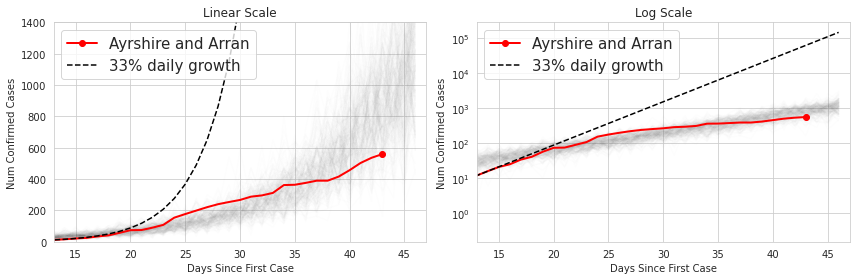

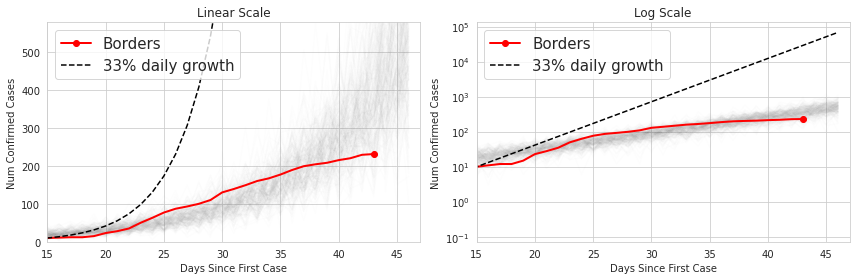

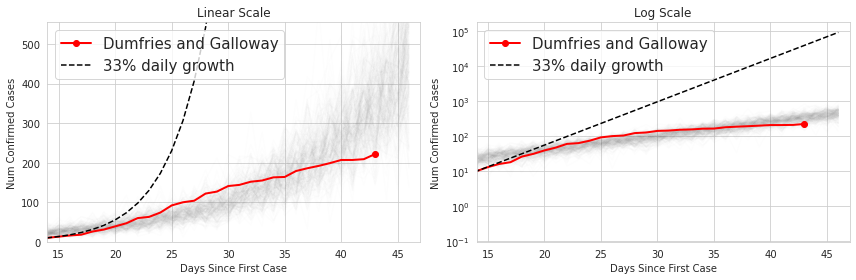

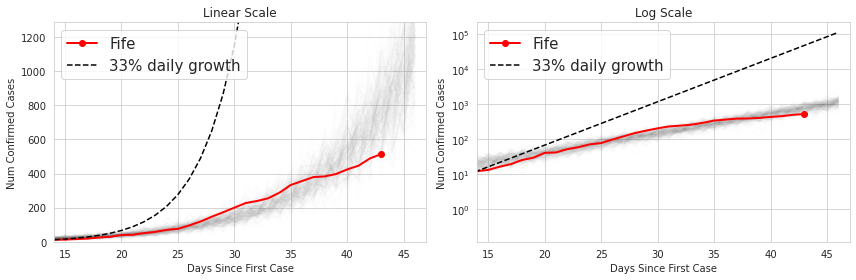

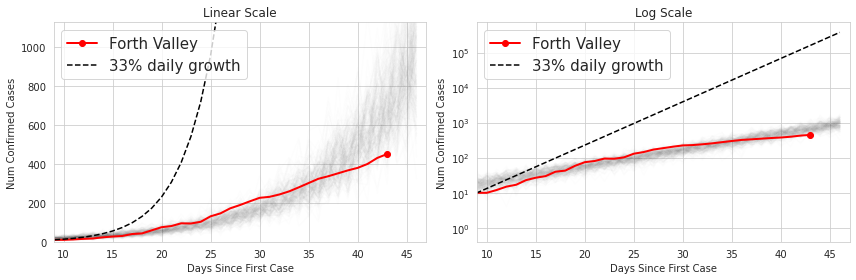

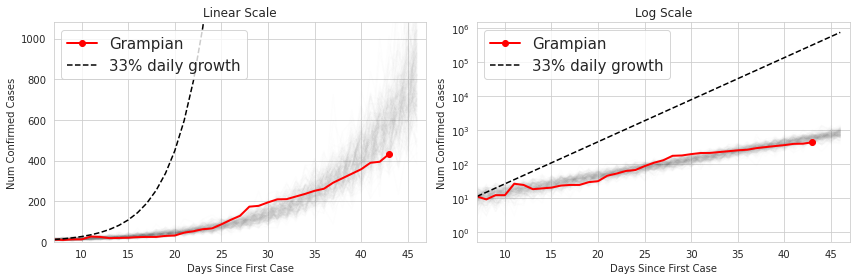

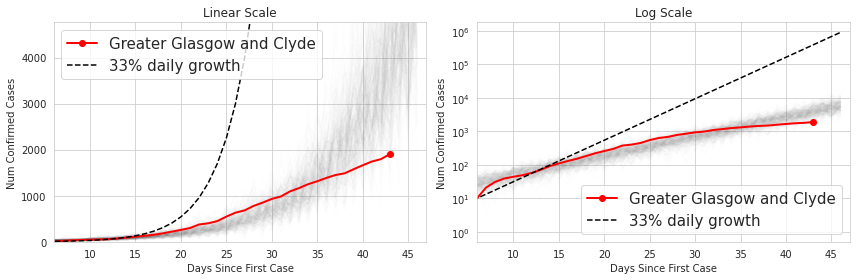

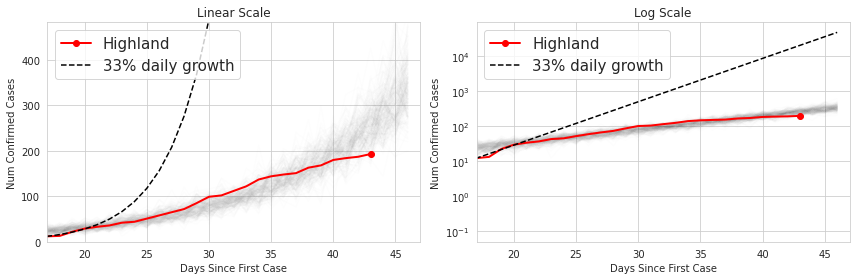

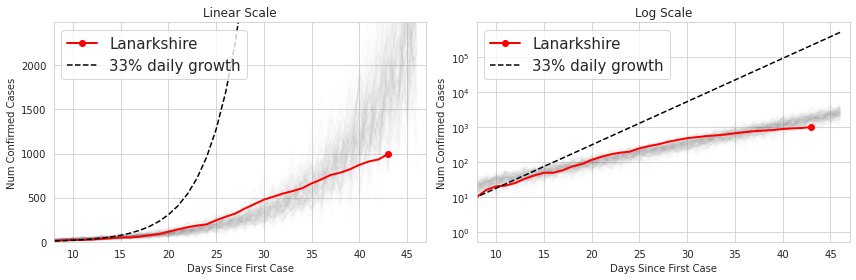

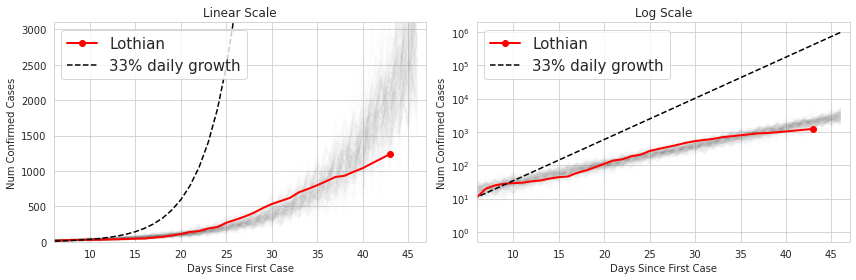

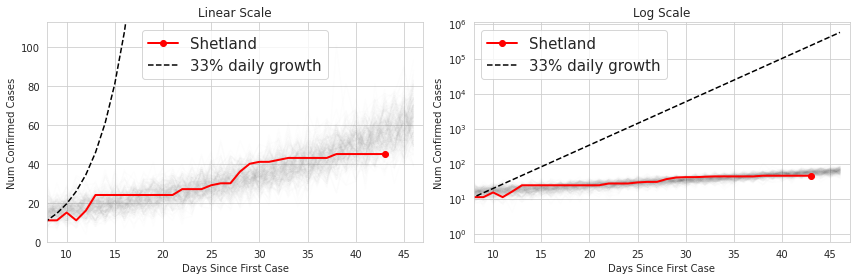

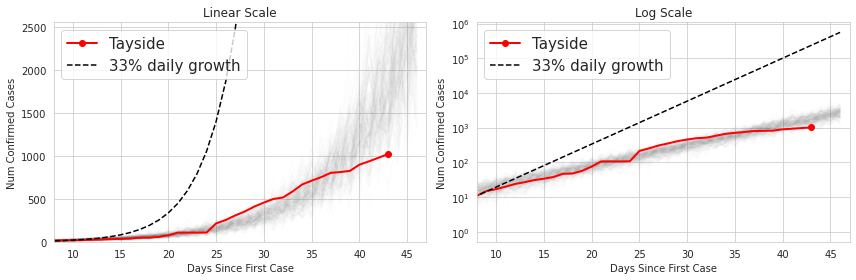

In [32]:
for r in regions:
    y = df_cases[r].iloc[:].values
    start = starting_days[r]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))

    ax = axes[0]
    for sim in post_pred[r]:
        ax.plot(sim, color='gray', alpha=0.01)
    ax.plot(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.plot(y[start] * 1.33 ** (np.arange(0, max_days)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, max_days)
    ax.set_ylim(0, 2.5*max(y))
    ax.set_ylabel('Num Confirmed Cases')
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Linear Scale')
    ax.legend(fontsize=15)

    ax = axes[1]
    for sim in post_pred[r]:
        ax.semilogy(sim, color='gray', alpha=0.01)
    ax.semilogy(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.semilogy(y[start] * 1.33 ** (np.arange(0, max_days)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, max_days)
    ax.set_xlabel('Days Since First Case')
    ax.set_ylabel('Num Confirmed Cases')
    ax.set_title('Log Scale')
    ax.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()
    

## Posterior Growth Rates Per Region

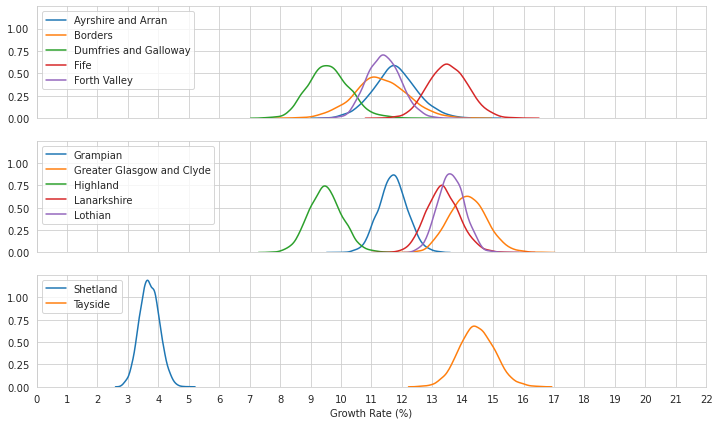

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharey=True, sharex=True)

for i in range(3):
    ax = axes[i]
    ax.grid()
    for r in regions[i*5: (i+1)*5]:
        sns.distplot((trace['slope_ind'][:, region_loc[r]] * 100 - 100), label=r, hist=False, ax=ax)
        ax.legend(loc=2)
        ax.grid()
    
ax.set_xlabel('Growth Rate (%)') 
ax.set_xticks(np.arange(0, 30))
ax.set_xlim(0, 22)
ax.grid()
plt.show()

Confidence intervals of growth rates for each region.

(Orkney and Western Isles ommitted due to lack of data)

In [34]:
for r in regions:
    print(f"{r} : \t{np.mean(trace['slope_ind'][:, region_loc[r]]):.6}  {pm.stats.hpd(trace['slope_ind'][:, region_loc[r]])}")

Ayrshire and Arran : 	1.11789  [1.104484   1.13201534]
Borders : 	1.11295  [1.09631579 1.12981764]
Dumfries and Galloway : 	1.09612  [1.08307202 1.10802611]
Fife : 	1.13528  [1.12357751 1.1477398 ]
Forth Valley : 	1.11418  [1.10382234 1.12400331]
Grampian : 	1.11711  [1.10806309 1.12550847]
Greater Glasgow and Clyde : 	1.14171  [1.12973223 1.15253633]
Highland : 	1.09495  [1.08535733 1.10587396]
Lanarkshire : 	1.13353  [1.12299852 1.14351934]
Lothian : 	1.13622  [1.1280806  1.14425029]
Shetland : 	1.03708  [1.03095608 1.04282673]
Tayside : 	1.14468  [1.13401601 1.15594487]


In [35]:
pm.stats.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intr_grp,6.679,0.871,5.016,8.328,0.016,0.011,2970.0,2970.0,3034.0,1999.0,1.0
intr_ind[0],7.380,1.410,4.844,10.077,0.030,0.022,2203.0,2058.0,2289.0,1686.0,1.0
intr_ind[1],3.916,0.990,2.192,5.764,0.023,0.018,1888.0,1597.0,2247.0,1596.0,1.0
intr_ind[2],6.743,1.237,4.567,9.098,0.022,0.016,3070.0,2965.0,3101.0,2040.0,1.0
intr_ind[3],3.331,0.594,2.284,4.468,0.012,0.009,2302.0,2198.0,2396.0,1831.0,1.0
intr_ind[4],6.800,0.954,5.133,8.639,0.020,0.014,2391.0,2243.0,2483.0,1710.0,1.0
intr_ind[5],5.079,0.632,3.870,6.226,0.012,0.009,2803.0,2705.0,2886.0,1947.0,1.0
intr_ind[6],13.813,1.898,10.397,17.413,0.037,0.027,2619.0,2562.0,2641.0,2302.0,1.0
intr_ind[7],5.263,0.854,3.815,6.930,0.017,0.012,2636.0,2459.0,2737.0,1923.0,1.0
intr_ind[8],8.176,1.099,6.178,10.274,0.022,0.015,2531.0,2513.0,2520.0,1790.0,1.0


## Model Diagnostics

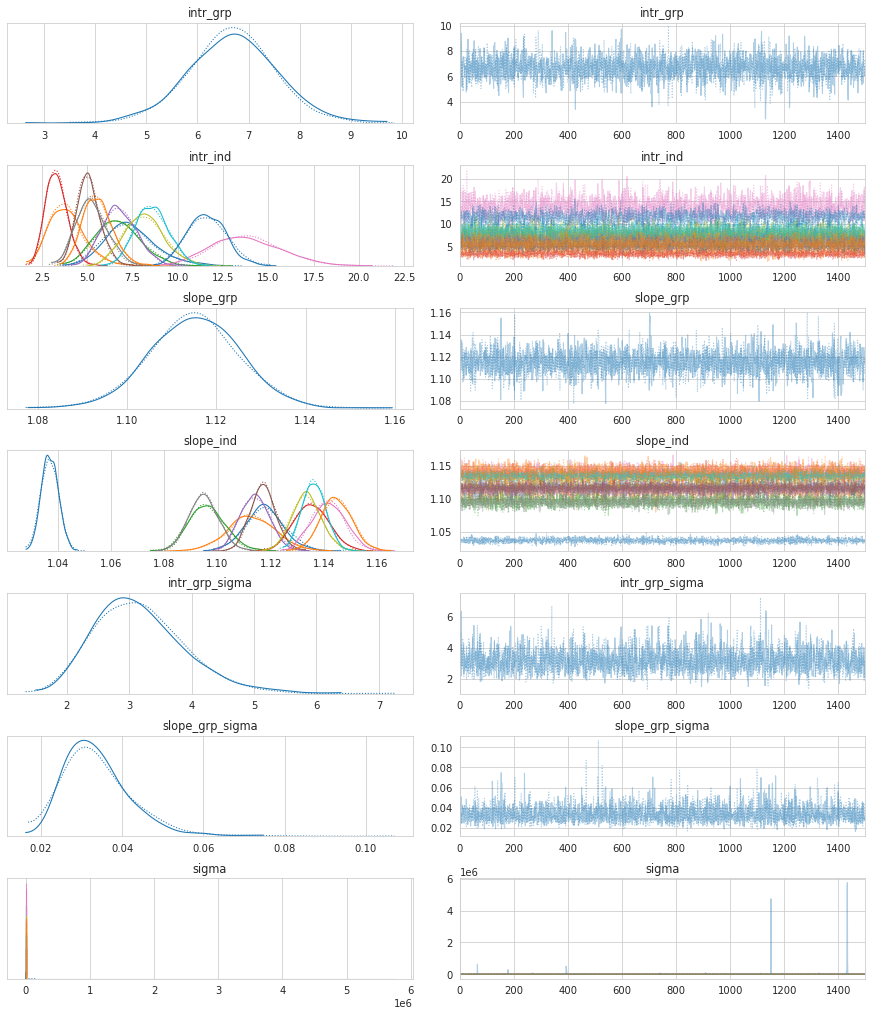

In [36]:
az.plot_trace(trace, compact=True);

In [37]:
19116 + 3000 * 20

79116